In [52]:
import numpy as np
import pandas as pd
import io
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
#import pandas_profiling

In [53]:
import sqlcl

In [54]:
# http://cas.sdss.org/dr15/en/tools/places/abell.aspx
#             Right Acension (ra),  Declination (dec)
# ra dec definition http://voyages.sdss.org/preflight/locating-objects/ra-dec/#:~:text=Computers%20and%20RA%20and%20Dec%20The%20Sloan%20Digital,The%20database%20is%20stored%20and%20accessed%20by%20computers.
# Abell 168   18.837, 0.26
# Abell 2255  258.1212,64.09654
# ABELL 1387  177.19526,51.61638

In [55]:
lines = sqlcl.query("select g.objid, g.ra, g.dec, g.u, g.g, g.r, g.i, g.z from galaxy g, dbo.fGetNearbyObjEq(18.837,0.26,5) n where g.objid = n.objid").read()
print (len(lines))

45470


In [56]:
strA = lines.decode("utf-8")

In [57]:
#dump created string of Sloan Digital Sky Survey (SDSS) Data
#print (strA)

In [58]:
file = StringIO(strA)

In [59]:
# create DataFrame of our SDSS Data
df = pd.read_csv(file, skiprows=1)

In [60]:
#print (df)

In [61]:
# read in our Kaggle training data
dz = pd.read_csv("C:\Sky Server Kaggle Dataset\Skyserver_SQL2_27_2018 6_51_39 PM.csv\Skyserver_SQL2_27_2018 6_51_39 PM.csv")

In [62]:
#dummp Kaggle Data Set
#print (dz)

In [63]:
# determine unique rows in each column
dz.nunique().to_frame().transpose()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1,10000,10000,9730,9817,9852,9890,9896,23,1,6,703,6349,3,9637,487,355,892


In [64]:
# print out number of Galaxie, Stars, Quasors in our Kaggle Data Set
occurrences = dz['class'].value_counts().to_frame().rename(index=str, columns={'class': 'Occurrences'})
print (occurrences)

        Occurrences
GALAXY         4998
STAR           4152
QSO             850


In [65]:
# dump column headers of Kaggle Dataset
dz.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [66]:
# split data into input and target variable(s)

X = dz.drop("class", axis=1).drop("redshift", axis=1).drop("plate", axis=1).drop("specobjid", axis=1).drop("mjd", axis=1).drop("fiberid", axis=1).drop("field", axis=1).drop("run", axis=1).drop("camcol", axis=1).drop("rerun", axis=1)
y = dz["class"]

In [67]:
# standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [68]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.10, random_state=42
)

In [69]:
# create the classifier
classifier = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf = classifier.fit(X_train, y_train)


In [70]:
# prediction on the test set
y_pred = clf.predict(X_test)
#print (y_pred)

Accuracy:  0.926


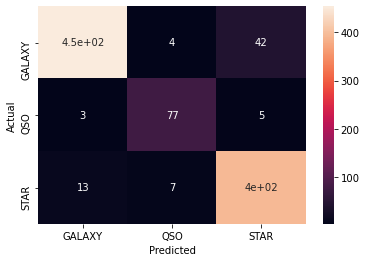

In [71]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
accscore = accuracy_score(y_test, y_pred)
print('Accuracy: ',accscore)
plt.show()

In [72]:
# check Important features
feature_importances_df = pd.DataFrame(
    {"feature": list(X.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

# Display Feater in order of Importance
feature_importances_df

,feature,importance
7,z,0.233451
5,r,0.175824
6,i,0.170455
4,g,0.163183
3,u,0.158333
1,ra,0.051725
2,dec,0.047028
0,objid,0.000000


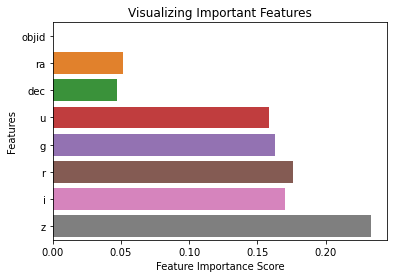

In [73]:
# plot importance (Visualization)
feature_imp = pd.Series(classifier.feature_importances_, index=X.columns)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.legend
plt.show()

In [74]:
# print out Score of identifying Galaxy, Quasar, Star
from sklearn.metrics import accuracy_score, f1_score
sortedlabels = clf.classes_
accscore = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred, average = None)
print(accscore)
for i in range(3):
    print((sortedlabels[i],f1score[i]), end=" ")


0.926
('GALAXY', 0.9360824742268041) ('QSO', 0.8901734104046243) ('STAR', 0.9218203033838973) 

In [75]:
# Now work on our Abell Dataset
# standardize the Abell Dataset
scaler = StandardScaler()
X_scaled_New = scaler.fit_transform(df)
# use classifier model on Abell DataSet
y_new = clf.predict(X_scaled_New)
print (len(y_new))

458


In [76]:
#dump our classification of the Abell Dataset
#print (y_new)

In [77]:
#dump our Abell Dataset
#print (df)

In [78]:
# combine Abell view with assigned class (GALAXY, STAR, QSO)
x = df
x['class'] = y_new
# dump our Abell Dataset with classifications
#print(x)

In [79]:
def highlight_class(val):
    if val == "GALAXY":
        color = 'orange'
    elif val == "STAR":
        color = 'blue'
    elif val == "QSO":
        color = 'red'
    return 'background-color: %s' % color


In [80]:
x.style.applymap(highlight_class, subset=['class'])

,objid,ra,dec,u,g,r,i,z,class
0,1237663784205615806,18.797636,0.198080,23.847270,23.189680,22.529370,21.985150,21.656500,GALAXY
1,1237663784205615812,18.800486,0.196920,25.613370,22.787060,22.165290,21.624660,21.009780,GALAXY
2,1237663784205616168,18.799563,0.188152,22.618470,23.173860,22.207970,21.885610,21.028570,GALAXY
3,1237663784205616180,18.806790,0.188326,24.969550,24.543020,22.753100,21.825460,21.146870,GALAXY
4,1237666339726819628,18.783880,0.216009,20.161550,18.586050,18.100740,17.870650,17.712980,STAR
5,1237663784205615786,18.792094,0.190465,23.451700,22.924620,22.218680,21.888900,21.616100,STAR
6,1237663784205615794,18.795142,0.188053,21.674660,20.804940,20.483710,20.369570,19.696550,GALAXY
7,1237663784205615784,18.790621,0.199029,25.572900,22.222690,21.682970,21.083950,21.181640,STAR
8,1237663784205616161,18.790850,0.192466,23.153510,23.543560,22.505910,21.809680,21.897380,GALAXY
9,1237663784205615765,18.787270,0.200176,23.709330,21.212350,19.584060,19.046590,18.633560,GALAXY
